# Concise Implementation of Softmax Regression

on Fashion_MNIST dataset

Choices
 - batch size: 256
 - softmax regression (one fully-connected layer with softmax activation function)
 - evaluate by Cross Entropy loss

In [ ]:
!pip install d2l==1.0.0a1.post0 # notice the precise version

In [1]:
from d2l import torch as d2l
import torch
from torch import nn
from torch.utils import data

## Data
For sake of simplicity in this example, we rely on a utility function in textbook's `d2l` library to download the Fashion-MNIST dataset and return DataLoaders for training and test sets.
 - PyTorch features functions in `torchvision.datasets` library to easily download many well-known datasets, that can be inserted into a DataLoader. Have a check at https://pytorch.org/vision/stable/datasets.html

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## Initializing Model


In this Fashion-MNIST case: softmax regression with one fully-connected layer
 - 10 outputs
 - again, `Sequential` is not really needed
 - we initialize weights $w_i$ i.i.d. $\textit N(0,0.01^2)$

Moreover:
 - an image is a matrix
 - NN multivariate input is a vector  
 $\Rightarrow$ need for "flattening" the matrices to vectors (also said "vectorization")

In [3]:
# PyTorch does not implicitly reshape the inputs. Thus we insert the "flatten"
# layer to reshape the inputs before the linear layer in our network
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m): # argument m shall be a layer
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights); # apply() will call init_weights() providing it with each layer of net as actual argument m


## Cross Entropy loss

In [4]:
loss = nn.CrossEntropyLoss()

## Optimization Algorithm



Minibatch SGD:
 - learning rate 0.1

In [5]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

## Training


First, we define a function to **train** for **one epoch** only.

The function needs to know the optimization algorithm, namely: `optimizer` is a general function to update the model parameters, which accepts the batch size as an argument.
It can be a framework's built-in optimization function, such as a `torch.optim.SGD` instance.

We can use a couple of utility functions of textbook's `d2l` library:
 - `Accumulator(`*n*`)` object for storing the performance measures (*n* many)
 - `accuracy()` to compute the classification **accuracy** = (relative) number of correct predictions
 - `evaluate_accuracy_gpu()` to compute the classification accuracy of a trained model on a given evaluation dataset (in GPU for sake of efficiency).

In [6]:
def train_epoch(net, train_iter, loss, optimizer):
    """For one epoch: the training loops over all batches once"""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, nb. of examples
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        metric.add(float(l) * len(y), d2l.accuracy(y_hat, y), y.size().numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

We can now define the function to train for **multiple epochs**:
 - using the model: `net`
 - on the training dataset accessed via DataLoader object: `train_iter`
 - for a number of epochs, specified by: `num_epochs`.
 - Optimization algorithm specified by: `optimizer`

At the end of each epoch, the model can also be evaluated on the test dataset accessed via `test_iter`.

We leverage the textbook's `d2l.Animator` utility class to visualize the training progress.

In [7]:
def train(net, train_iter, test_iter, loss, num_epochs, optimizer):
    """Train a model: loop through more epochs"""
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, optimizer)
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    return train_loss, train_acc

After defining the functions, we can now start training the model.


Loss:  0.42067777382532756
Accuracy:  0.8560166666666666


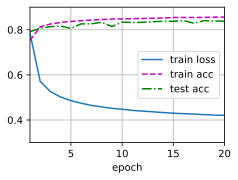

In [8]:
num_epochs = 20
train_loss, train_acc = train(net, train_iter, test_iter, loss, num_epochs, trainer)
print("Loss: ", train_loss)
print("Accuracy: ", train_acc)

This algorithm has converged to a solution
that achieves a decent loss and accuracy.


## Summary

* Using high-level APIs, we can implement softmax regression much more concisely.
* From a computational perspective, implementing softmax regression has intricacies. Note that in many cases, a deep learning framework, such as PyTorch, takes additional precautions beyond these most well-known tricks to ensure numerical stability, saving us from even more pitfalls that we would encounter if we tried to code all of our models from scratch in practice.



## Exercises

1. Try adjusting the hyperparameters, such as the batch size [50, 100, 200, 256 * ], number of epochs [1, 10 * , 30, 50] , and learning rate [0.01 *, 0.1, 0.3], and plot the accuracy vs the hyperparameters (one plot for each hyperparameter) to highlight the best. When exploring one parameter, fix the others setting the value with the *.

1. Why might the test accuracy decrease after a while, increasing the number of epochs for training? How could we fix this?


## Solutions 


1. In this possible solution we can set the 3 hyperparameters to single value or a list of values depending on which one we want to explore, by simply changing the initial assignments

Loss:  0.6064831599871318
Accuracy:  0.80755


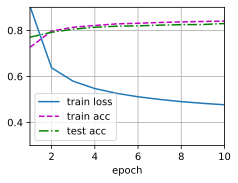

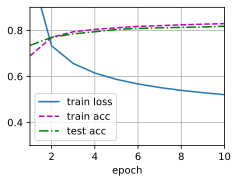

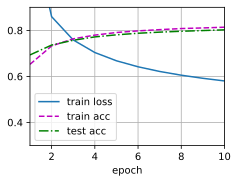

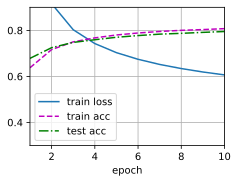

In [ ]:
%matplotlib inline

batch_size = [50, 100, 200, 256]       # [50, 100, 200, 256]
learning_rate = [0.01]          # [0.01 , 0.1, 0.3]
epochs = [10]       # [1, 10, 30, 50]
acc = list()

loss = nn.CrossEntropyLoss()

for b in batch_size:
    for l in learning_rate:
        for e in epochs:
            print(f'batch_size: {b} - learning_rate: {l} - epochs {e}')
            train_iter, test_iter = d2l.load_data_fashion_mnist(b)
            net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

            net.apply(init_weights);
            trainer = torch.optim.SGD(net.parameters(), lr=l)

            train_loss, train_acc = train(net, train_iter, test_iter, loss, e, trainer)
            print("Loss: ", train_loss)
            print("Accuracy: ", train_acc)
            acc.append(train_acc)


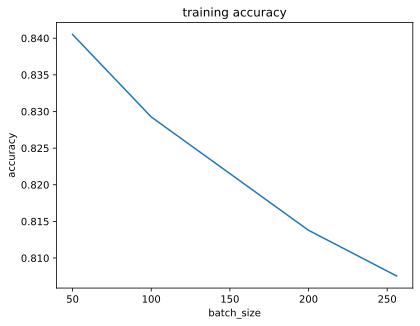

In [ ]:
from matplotlib import pyplot as plt
plt.plot(batch_size, acc)
plt.xlabel('batch_size')
plt.ylabel('accuracy')
plt.title('training accuracy')
plt.show()

2. Training by more epochs might yield a model with very low training loss value, indicating a tight fit with the training set, while not being able to generalize to unseen data as in the test set. That is, we can incur overfitting when the model is too complex, so we could reduce the model complexity.